# Numerical solution to the Taylor-Goldstein equation

The eigenvalue problem for internal wave modes with shear is [cf. Grimshaw et al., 2004]

$$
\frac{d}{dz}\lbrace\left[c-U(z)\right]^2\frac{d \phi}{dz} \rbrace + N^2(z)\phi = 0
$$

with boundary conditions $\phi(0) = \phi(-H) = 0$. Many papers omit details for solving this numerically, so here we present a solution using the shooting method for boundary value problems. This method has been applied to similar wave-like eigenvalue problems (e.g., Hazel, 1972; Winters et al...). 

The numerical solution method is as follows: 

- Break up Eq (1) into a system of (two) first-order ODEs by first setting

$$
y_1 = [c-U(z)]^2\phi
$$

$$
y_2 = y_1' \equiv \frac{dy_1}{dz}
$$

 - The two ODEs are
 
$$
\frac{d y_2}{dz}  = -\frac{N(z)^2}{[c-U(z)]^2}y_1
$$

$$
\frac{dy_1}{dz} = y_2
$$

 - Integrate the system by setting $y_1(0) = 0$ (the top boundary condition) and guessing initial values for $y_2(0)$ and $c$. This is the shooting step where we use `odeint` in scipy.
 
 - The goal is to find values of $y_2(0)$ and $c$ so that the boundary condition $y_1(-H)=0$.
 
 - We use an optimization routine `least_squares` in scipy to perform this task. This routine allows one to set bounds on the parameters $y_2(0)$ and $c$ i.e., return physically meaningful results. 
 
 - One thing to note is that the final optimized solution is still dependent on the initial conditions. To ensure that we are searching for the desired mode, we use $c$ from the solution to the shear-free eigenvalue problem as an intitial guess.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse import linalg
from scipy.optimize import least_squares, newton_krylov, fsolve
from scipy.integrate import solve_bvp, odeint
from scipy.interpolate import interp1d

from iwaves.utils.isw import iwave_modes

%matplotlib inline

In [3]:
# Discretized version of the two ODEs
def odefun(phi, y, c, Fn, Fu):

    phi1, phi2 = phi
    dphi1 = phi2
    uc2 = (c - Fu(y))**2
    dphi2 = -Fn(y)/uc2 * phi1

    return [dphi1, dphi2]

In [6]:
# This is the objective function we are trying to optimize i.e. return y_1(-H) = 0 
def objective(args, Fn, Fu):
    phi_1 = 0. # Bottom BC (hard-wired for now...)
    u2_0, cn = args
    dspan = np.linspace(0, d)
    U = odeint(odefun2, [phi_1, u2_0], dspan, args=(cn, Fn, Fu))
    u1 = U[:,0]
    u2 = U[:,1]
    # Ensure the top bc is zero
    return u1[-1]#, u2[-1]

In [46]:
def tgsolve(z, U, N2, mode):
    """
    Taylor-Goldstein equation solver
    """

    dz = np.abs(z[1]-z[0]) # Assume constant spacing

    # Guess the initial conditions from the shear-free solution
    phin, cn = iwave_modes(N2, dz)
    cguess = cn[mode]
    phi_2_guess = 1.05

    # Functions mapping the velocity and N^2 profile to any height
    # (Use interpolation here although we could ascribe an analytic expression)
    Fn = interp1d(z, N2, kind=2, fill_value='extrapolate')
    Fu = interp1d(z, U, kind=2, fill_value='extrapolate')

    # Optimization step
    soln = least_squares(objective, [phi_2_guess, cguess], xtol=1e-12, \
            bounds=((0,cguess-cguess*0.55), (2., cguess+cguess*0.55)),\
            args=(Fn,Fu))

    # Go back and get the optimal profile using the solution
    phi_2, cn = soln['x']
    phiall = odeint(odefun2, [0, phi_2], z, args=(cn,Fn,Fu))
    phi = phiall[:,0]

    # Normalize the profile
    idx = np.where(np.abs(phi)==np.abs(phi).max())[0][0]
    phi /= phi[idx]

    return phi, cn



In [44]:
# Create some initial data
d = 500
Nz = 250
N = 0.01
S = 0.001

RHO0 = 1024.
GRAV = 9.81

# Create the density initial conditions
z = np.linspace(0, d, Nz)


# Idealized density profoile
# drho, dp, Li, rho0
#rhoz = ideal_rho(z, drho, dp, Li) + sig0 # Summer

N2 = N*N*np.ones_like(z)
U = S*z
Uzz = U*0.

mode = 0

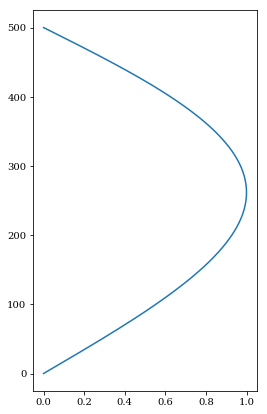

In [45]:
phi, cn = tgsolve(z,U,N2,mode)

plt.figure(figsize=(4,7))
plt.plot(phi,z)
plt.show()

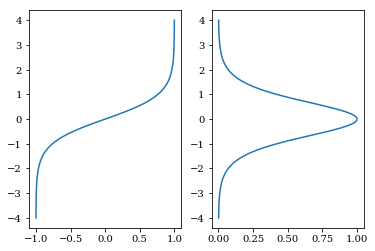

In [41]:
# Hazel, 1972 - Mixing layer model

Nz = 100
z = np.linspace(-4,4, Nz)

U = np.tanh(z)

N2 = 1/np.cosh(z)**2 # sech^2(z)

mode=0

plt.figure()
plt.subplot(121)
plt.plot(U,z)
plt.subplot(122)
plt.plot(N2,z)
plt.show()

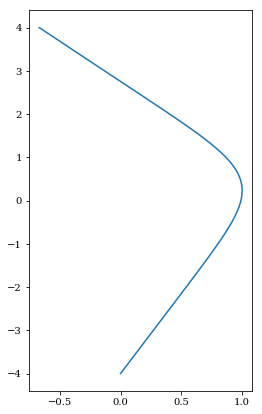

In [42]:
phi, cn = tgsolve(z,U,N2,mode)

plt.figure(figsize=(4,7))
plt.plot(phi,z)
plt.show()


In [36]:
phin, cn = iwave_modes(N2, dz)
cn[0]

43.476199428204112